## Part 1

<br>

🎡 https://youtu.be/aOMLDcT3jh0

<br>

- 해당 유튜브의 가이드대로 코드를 필사 하였다. (part 1 ~ part3)
- Pytorch API를 사용해서 pretrained DenseNet 201를 임포트 하여 분류기를 만드는 방식.

> 구글 드라이브의 파일을 `wget`으로 다운 받는 방법!
- https://deeplify.dev/server/bash/download-google-drive-file-in-terminal

<br>

> 데이터셋을 공유 받을 수 있는 구글 드라이브  
- https://drive.google.com/drive/folders/1cnQHqa8BkVx90-6-UojHnbMB0WhksSRc

In [ ]:
# Make sure that you have a GPU runtime for this.

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK" -O 256_ObjectCategories.tar && rm -rf ~/cookies.txt

--2022-08-18 16:17:24--  https://docs.google.com/uc?export=download&confirm=t&id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.138, 74.125.195.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/onb4dir8k94l4bo8e4rmqtcpn0v54ej7/1660839375000/15424859768005087218/*/1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK?e=download&uuid=5c5ce7a2-e52f-4296-afe9-12d54236379b [following]
--2022-08-18 16:17:24--  https://doc-04-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/onb4dir8k94l4bo8e4rmqtcpn0v54ej7/1660839375000/15424859768005087218/*/1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK?e=download&uuid=5c5ce7a2-e52f-4296-afe9-12d54236379b
Resolving doc-04-24-docs.googleusercontent.com (doc-04-24-docs.googleusercontent.com)... 74.125.195.132, 

In [ ]:
# Will take a bit of time. Its kind of large. Its done
# We are using a library called Pytorch Ignite to simplify our training.
# When we use this library, we won't have to write a custom training loop, 
# It will give us our training loop.
# Colab doesn't have it installed, so we will have to install it ourselves.

!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 9.9 MB/s 


In [ ]:
# for unzipping tar files
!tar -xf 256_ObjectCategories.tar

In [ ]:
# Now we will import all modules needed.
import torch
import torchvision
from torchvision import datasets, transforms  # For loading out dataset
from torch import nn, optim     # NN module and optimizers
from torch.nn import functional as F   # Certain functions, like sigmoid and tanh and relu
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models   # This is where we get out model.

In [ ]:
import matplotlib.pyplot as plt  # We need this to show the image
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# For retina display only

In [ ]:
import numpy as np

In [ ]:
# Now we will import pytorch ignite

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import  ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix

In [ ]:
# Now we will load out data in. For this we will write a helper function
def get_data_loaders(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()])
    # Changing the image so that we can use it in out model
    all_images = datasets.ImageFolder(data_dir, transform=transform)
    train_images_len = int(len(all_images) * 0.75)  # 75% of images will be training
    valid_images_len = int((len(all_images) - train_images_len)/2)
    test_images_len = int(len(all_images) - train_images_len - valid_images_len)

    train_data, val_data, test_data = random_split(all_images, [train_images_len, valid_images_len, test_images_len])
    train_loader = DataLoader(train_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return (train_loader, val_loader, test_loader), all_images.classes

In [ ]:
(train_loader, val_loader, test_loader), classes = get_data_loaders('/content/256_ObjectCategories', 64)

In [ ]:
print(classes)

['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '057.dolphin-101', '058.doorknob', '059.drinking-straw', '060.du

In [ ]:
# We will build a helper function to format the text
# Goal is to turn a string like 007.bat to bat

# def formatText(string):
#     string = string[4:]
    
#     return string.replace('-', ' ')

# 위의 함수를 람다 표현식으로 작성한다.
# 람다 표현식은 list comprehension에서만 작성할 수 있는줄 알았는데 그냥도 사용가능한 모양
formatText = lambda string: string[4:].replace('-', ' ')

print(formatText(classes[0]))   

ak47


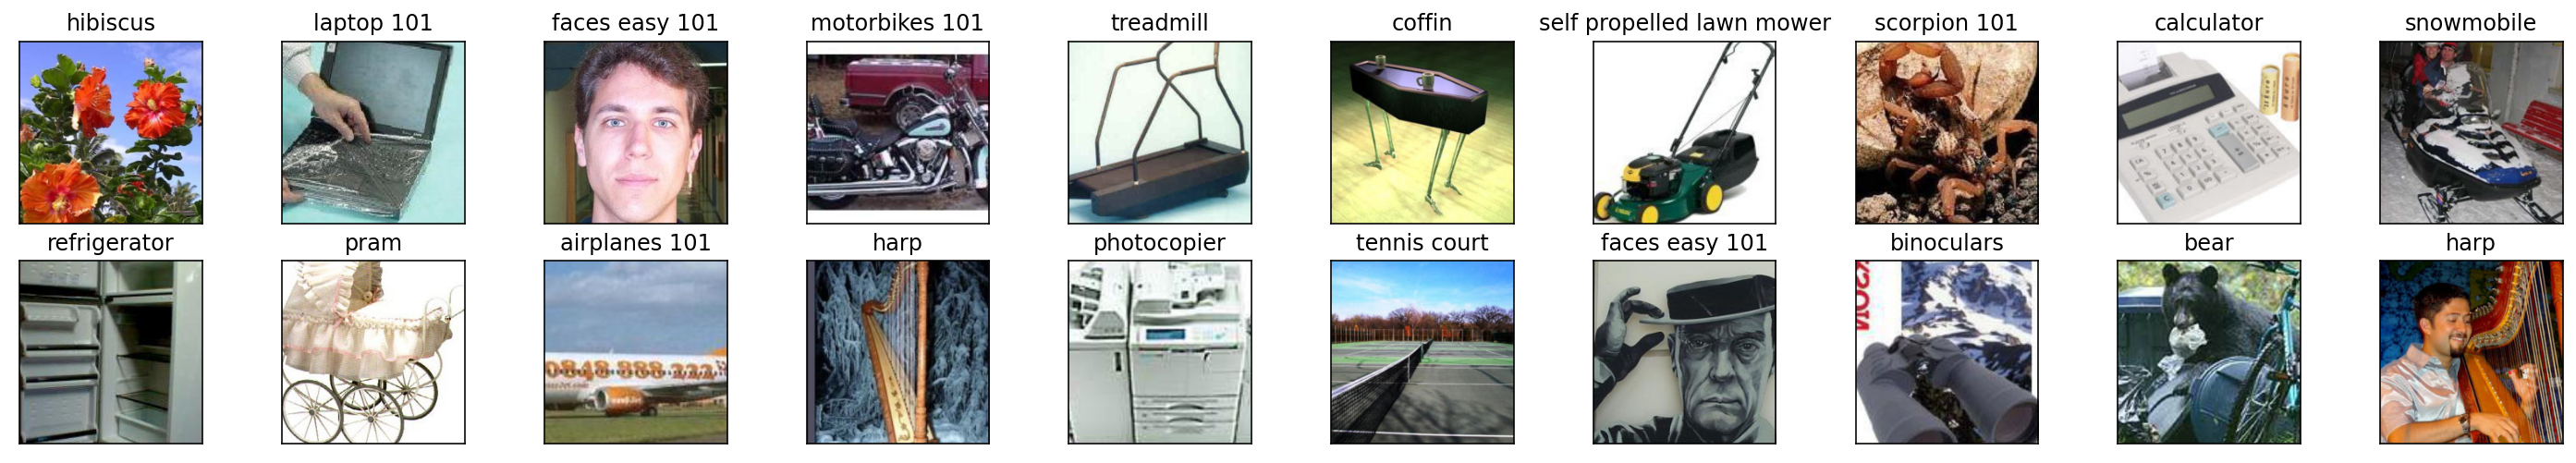

In [ ]:
# Let's display a few training images

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):    # only taking 20 images
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[ ], yticks=[ ])
    # We don't need axes for the images
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(formatText(classes[labels[idx]]))
    # Take a few seconds

## Part 2
- https://youtu.be/SXgl2Jz-TR0

In [ ]:
# There are 256 different types of objects in the dataset,
# Thats why it is called caltech 256

In [ ]:
# Now we will load in the model now that we have loaded in the dataset 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**pyTorch 공식 문서**  
-  https://pytorch.org/vision/main/models/generated/torchvision.models.densenet201.html

In [ ]:
model = models.densenet201(pretrained=True)   # We will use densenet 201
# The following code will work with any of the densenet models, like 121, 169 and 161
# If you want to load in something else, like resnet, then you will have to change the code later on.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

> model_plot 같이 아키텍쳐를 출력해보려고 했지만 잘 되지 않음!

In [ ]:
import torchvision
import torch.onnx

# model은 앞에서 설정했음. 아래 코드는 레즈넷 예시
# model = torchvision.models.resnet101(pretrained=False)
params = model.state_dict()
dummy_data = torch.empty(1, 3, 224, 224, dtype = torch.float32)
torch.onnx.export(model, dummy_data, 'output.onnx')

> - 파이토치 공식 문서 : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  
- [Implementation 2] DenseNet Ablation Study with Tensorflow코드 구현에 참고  (깃허브 주소 링크로 넣기)

In [ ]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# We need to chnage the last layer to have a output shape of 257
print(model.classifier.in_features)
print(model.classifier.out_features)

1920
1000


In [ ]:
for param in model.parameters():
    param.requires_grad = False   
    # We are freezing model since it was trained on Imagenet and we dont need to trian that part again

In [ ]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)

257


In [ ]:
# There we go, now we will move our model to GPU
model = model.to(device)

In [ ]:
# Defining our optimizer and loss function
criterion = nn.CrossEntropyLoss()   # This is our loss function
optimizer = optim.Adam(model.classifier.parameters())   # We need to feed in the parameters to the optimizer

In [ ]:
# Now we will train our model
training_history = {'accuracy' : [], 'loss' : []}
validation_history = {'accuracy' : [], 'loss' : []}

In [ ]:
# Now we wilil use pyTorch Ignite's features
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model,
                                        device=device,
                                        metrics={
                                            'accuracy' : Accuracy(),
                                            'loss' : Loss(criterion),
                                            'cm' : ConfusionMatrix(len(classes))
                                        })

# Creating event handlers to show our training progress
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
    print('.', end='')

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['loss']
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print()
    print(f'Training results - Epoch : {trainer.state.epoch} Avg accuracy : {accuracy} Loss : {loss}')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['loss']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print()
    print(f'Validation results - Epoch : {trainer.state.epoch} Avg accuracy : {accuracy} Loss : {loss}')

In [ ]:
trainer.run(train_loader, max_epochs=5)

.......................................................................................................................................................................................................................................................................................................................................................................
Training results - Epoch : 1 Avg accuracy : 89.61446307993901 Loss : 0.5639382759747332

Validation results - Epoch : 1 Avg accuracy : 83.22007318348145 Loss : 0.7776548282924399
.......................................................................................................................................................................................................................................................................................................................................................................
Training results - Epoch : 2 Avg accuracy : 94.11457198867349 Loss : 0.3137900792651383

Validation r

State:
	iteration: 1795
	epoch: 5
	epoch_length: 359
	max_epochs: 5
	output: 0.06468789279460907
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Part 3
- https://youtu.be/vdgrbc0Cvks

Text(0.5, 1.0, 'Validation Loss')

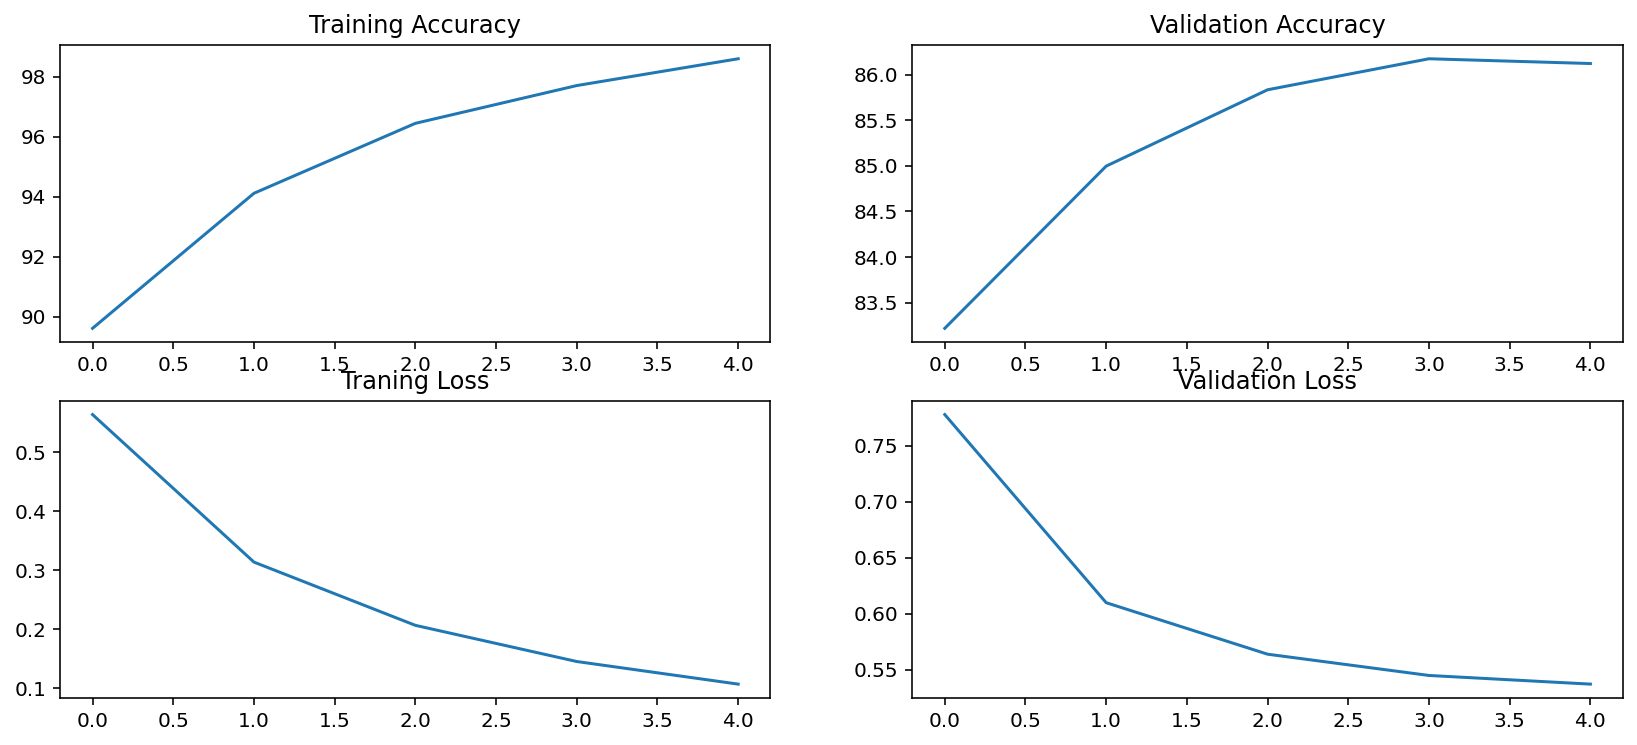

In [ ]:
# Its finished training. We will test it now
# Lets plot the accuracy and loss
fig, axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(14)
axs[0, 0].plot(training_history['accuracy'])
axs[0, 0].set_title('Training Accuracy')
axs[0, 1].plot(validation_history['accuracy'])
axs[0, 1].set_title('Validation Accuracy')
axs[1, 0].plot(training_history['loss'])
axs[1, 0].set_title('Traning Loss')
axs[1, 1].plot(validation_history['loss'])
axs[1, 1].set_title('Validation Loss')

In [ ]:
# you can see that the loss continued decreasing whild the accuracy continued increasing
# the rate the loss and accyracy decreases slowed down around 4 epoch
# we are gonna test the model now

In [ ]:
test_loss = 0.0
class_correct = np.zeros((len(classes)))
class_total = np.zeros((len(classes)))
model.eval()   # Setting model to evaluation mode

for data, target in test_loader:    # Iterating through the test loader
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)    # We feed in the data to the model
    loss = criterion(output, target)   # This is how we calculate the loss
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # If the data is on GPU, which is for me, then I have to convert it to cpu tensor and  they numpy array
    if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
test_loss /= len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))    # f 포매팅을 쓰지 않은 것은, test_loss를 소숫점 6자리의 실수로 나타내기 위해서이다.

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {} ({}/{})'.format(
            classes[i], 100*class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print(f'Test Accuracy of  {classes[i]}: N/A (since there are no examples)')

print('Test Accuracy Overall: {} ({}/{})'.format(
    100*np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)
))

Test Loss: 0.556879

Test Accuracy of 001.ak47: 91.66666666666667 (11.0/12.0)
Test Accuracy of 002.american-flag: 78.57142857142857 (11.0/14.0)
Test Accuracy of 003.backpack: 91.66666666666667 (22.0/24.0)
Test Accuracy of 004.baseball-bat: 33.333333333333336 (7.0/21.0)
Test Accuracy of 005.baseball-glove: 93.33333333333333 (14.0/15.0)
Test Accuracy of 006.basketball-hoop: 71.42857142857143 (5.0/7.0)
Test Accuracy of 007.bat: 100.0 (9.0/9.0)
Test Accuracy of 008.bathtub: 84.0 (21.0/25.0)
Test Accuracy of 009.bear: 92.85714285714286 (13.0/14.0)
Test Accuracy of 010.beer-mug: 60.0 (6.0/10.0)
Test Accuracy of 011.billiards: 92.6829268292683 (38.0/41.0)
Test Accuracy of 012.binoculars: 96.0 (24.0/25.0)
Test Accuracy of 013.birdbath: 83.33333333333333 (10.0/12.0)
Test Accuracy of 014.blimp: 92.3076923076923 (12.0/13.0)
Test Accuracy of 015.bonsai-101: 81.81818181818181 (18.0/22.0)
Test Accuracy of 016.boom-box: 80.0 (4.0/5.0)
Test Accuracy of 017.bowling-ball: 80.0 (8.0/10.0)
Test Accuracy o

In [ ]:
# This is pretty good, we got most of the images classified correctly
# We can try out the model now
from PIL import Image
import requests
from io import BytesIO 

In [ ]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224, 224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    return out

In [ ]:
model.eval()   # just making sure

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def predict(model, filepath, show_img=False, url=False):
    if url:
        response = requests.get(filepath)
        im = Image.open(BytesIO(response.content))
    else:
        im = mage.open(filepath)
    
    if show_img:
        plt.imshow(im)
    im_as_tensor = apply_test_transforms(im)
    minibatch = torch.stack([im_as_tensor])
    
    if torch.cuda.is_available():
        minibatch = minibatch.cuda()
    pred =model(minibatch)
    _, classnum = torch.max(pred, 1)

    return formatText(classes[classnum])

'eyeglasses'

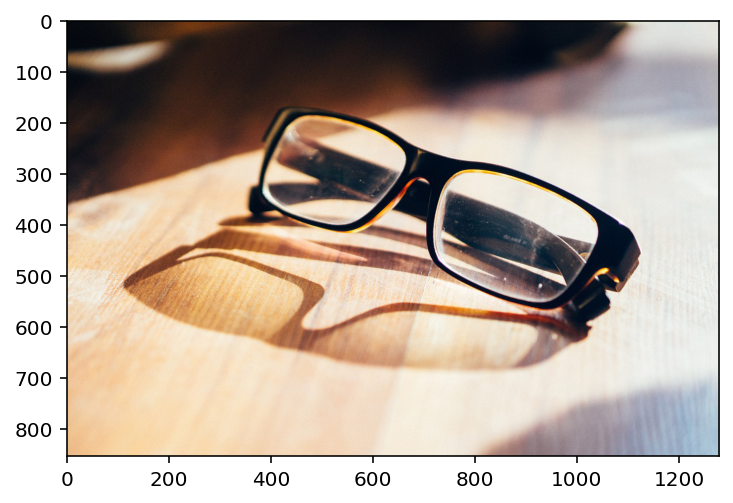

In [ ]:
# We can test this out now.
# https://storage.needpix.com/rsynced_images/eyeglasses-933384_1280.jpg - cat
predict(model, 'https://storage.needpix.com/rsynced_images/eyeglasses-933384_1280.jpg', show_img=True, url=True)

'fighter jet'

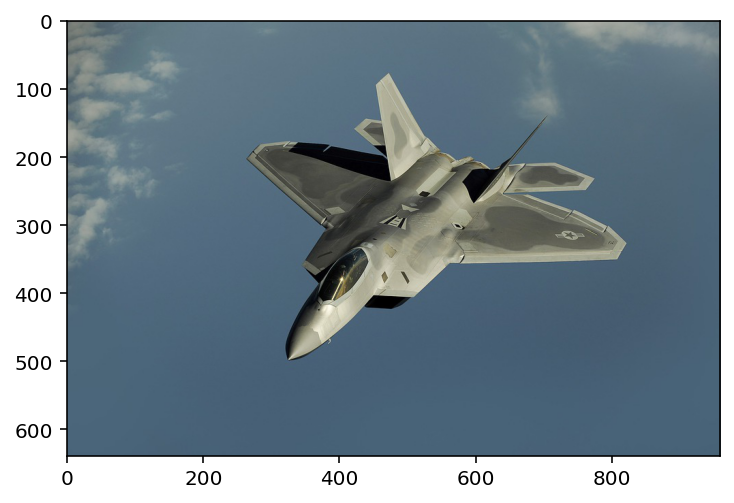

In [ ]:
predict(model, 'https://cdn.pixabay.com/photo/2012/10/26/01/35/fighter-jet-63032_960_720.jpg', show_img=True, url=True)

'owl'

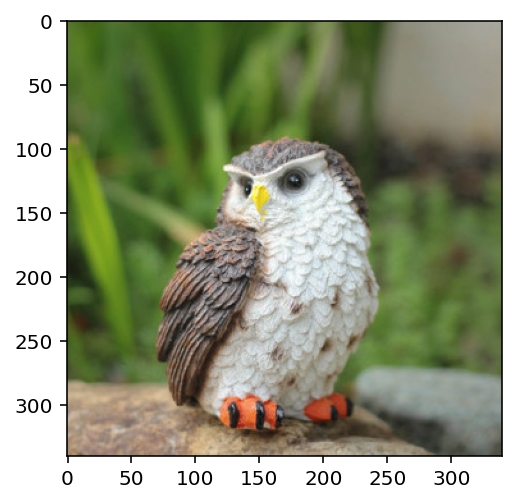

In [ ]:
predict(model, 'https://search.pstatic.net/common/?src=http%3A%2F%2Fshop1.phinf.naver.net%2F20211115_179%2F1636956225545ADuAW_JPEG%2F7nt3s1h_20211112161516879125.jpg&type=a340', show_img=True, url=True)

'teapot'

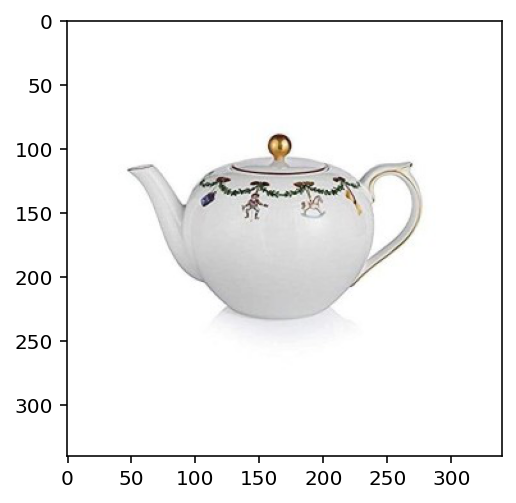

In [ ]:
predict(model, 'https://search.pstatic.net/common/?src=http%3A%2F%2Fshop1.phinf.naver.net%2F20220121_221%2F1642755795888pcBmf_JPEG%2F43891691619562710_454055509.jpg&type=a340', show_img=True, url=True)

'teapot'

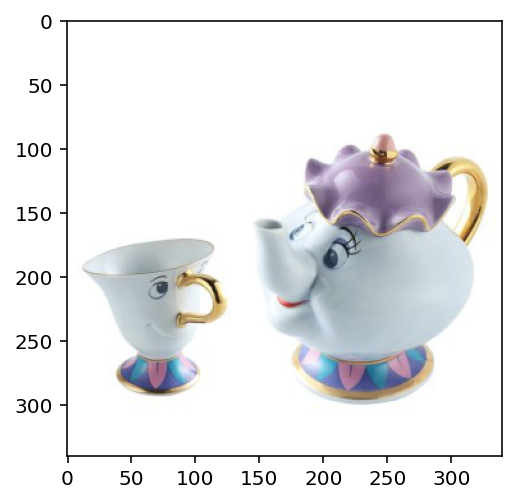

In [ ]:
predict(model, 'https://search.pstatic.net/common/?src=http%3A%2F%2Fshop1.phinf.naver.net%2F20210422_278%2F1619097754071R2ldr_JPEG%2F20233642776949314_28645743.jpeg&type=a340', show_img=True, url=True)

'trilobite 101'

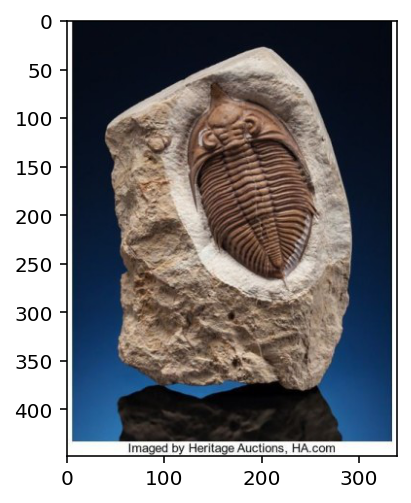

In [ ]:
predict(model, 'https://search.pstatic.net/sunny/?src=https%3A%2F%2Fi.pinimg.com%2Foriginals%2F18%2F6e%2Fa1%2F186ea1c8d8f1553cf2f3951741a67d4f.jpg&type=a340', show_img=True, url=True)

In [ ]:
# It has classified everython correctly.